In [1]:
import dezero
import numpy as np
import dezero.functions as F

from dezero import Variable
from dezero.utils import numerical_diff

### **1. 변수 (Variable)**

In [4]:
data = np.array(1.0)
x = Variable(data)      # x는 Variable의 인스턴스

print(f"val: {x.data}, dim: {x.data.ndim}")

val: 1.0, dim: 0


### **2. 함수 (Function)**

In [5]:
x = Variable(np.array(10))
f = F.Square()    # Function 클래스를 상속
y = f(x)        # 입력으로 사용되는 x는 Variable 인스턴스

print(f"val: {y.data}, type: {type(y)}")

val: 100, type: <class 'dezero.core.Variable'>


### 3. **함수 연결 (Composite Function)**

In [6]:
sqr = F.Square()
exp = F.Exp()

# 합성 함수를 통해 "계산 그래프" 생성
x = Variable(np.array(0.5))
h1 = sqr(x)
h2 = exp(h1)
y = sqr(h2)

print(f"val: {y.data: .4f}, type: {type(y)}")

val:  1.6487, type: <class 'dezero.core.Variable'>


### **4. 수치 미분 (Numerical Differential)**

- 중앙 차분: x + h와 x - h의 값을 이용한 미분 (오차 최소화)
- 정확도: 유효 자릿수 누락으로 인한 오차 발생
- 계산 비용: 편미분 수행 시(변수가 여러 개인 경우), 각 변수를 찾아 연산을 수행해주어야 함

In [7]:
def f(x):
    sqr = F.Square()
    exp = F.Exp()

    return sqr(exp(sqr(x)))

x = Variable(np.array(0.5))
dy = numerical_diff(f, x) # 중앙 차분을 이용한 수치 미분
print(dy)

3.2974426293330694


### **5. 역전파 (Backward Pass)**

- 수치 미분과 달리, 자신과 관계된 정보만을 계산
- 연쇄 법칙을 이용하여 미분을 수행하기 때문에 한 번의 역전파로 미분값 계산 가능

In [8]:
# 서로 다른 인스턴스를 생성해야만 forward 시 저장한 정보가 겹치지 않음
sqr1 = F.Square()
exp = F.Exp()
sqr2 = F.Square()

# 순전파 (Forward pass)
x = Variable(np.array(0.5))
h1 = sqr1(x)
h2 = exp(h1)
y = sqr2(h2)

# 역전파 (Backward pass)
y.grad = np.array(1.0)  # y의 gradient를 1로 설정 (자기 자신이므로)
h2.grad = sqr1.backward(y.grad)
h1.grad = exp.backward(h2.grad)
x.grad = sqr2.backward(h1.grad)

print(x.grad) # 미분값

3.297442541400256


### 6. **자동 미분 (Auto Gradient)**

In [9]:
sqr1 = F.Square()
exp = F.Exp()
sqr2 = F.Square()

# 순전파 (Forward pass)
x = Variable(np.array(0.5))
h1 = sqr1(x)
h2 = exp(h1)
y = sqr2(h2)

# 역전파
y.grad = 1.0
y.backward()
print(x.grad)

3.297442541400256


### **7. 편의성 개선**

- 각 함수 및 클래스의 목적에 맞게 파일 분리 (Refactorizing)
- functions의 각 클래스를 함수로 호출할 수 있도록 추가
- Variable: backward 호출을 재귀에서 반복문으로 변경 / ndarray 자료형만 입력으로 허용
- Function: np.ones_like를 활용하여 data와 동일한 자료형으로 gradient 초기화
- as_array: 0차원 ndarray 계산 결과인 스칼라 값을 다시 array로 변경

In [10]:
x = Variable(np.array(0.5))
y = F.square(F.exp(F.square(x)))
y.backward()
print(x.grad)

3.297442541400256


### **8. 테스트 (Test)**

In [11]:
# 특정 테스트 코드 실행
!python3 -m unittest tests/test_square.py

...
----------------------------------------------------------------------
Ran 3 tests in 0.002s

OK


In [12]:
# 모든 테스트 코드 실행
!python3 -m unittest discover tests

...
----------------------------------------------------------------------
Ran 3 tests in 0.001s

OK


### **9. 가변 길이 (Variable Length)**

In [13]:
x0, x1 = Variable(np.array(2.0)), Variable(np.array(3.0))

z = F.square(x0) + F.square(x1)
z.backward()

print(f"forward: {z.data}\nbackward: {x0.grad}, {x1.grad}")

forward: 13.0
backward: 4.0, 6.0


### **10. Variable 완성**

- 같은 변수 반복 사용 문제 해결
- 복잡한 계산 그래프 시 각 함수의 우선순위 문제 해결

In [14]:
x = Variable(np.array(2.0))
a = F.square(x)
y = F.square(a) + F.square(a)
y.backward()

print(f"forward: {y.data}\nbackward: {x.grad}")

forward: 32.0
backward: 64.0


### **11. 메모리 최적화**

- weakref를 통한 순환 참조 문제 해결
- 중간 변수에 대한 미분값 제거
- 역전파 필요 여부에 따른 Gradient 계산 모드 설정

In [15]:
x0, x1 = Variable(np.array(2.0)), Variable(np.array(3.0))
z = x0 + x1
y = x0 + z
y.backward()

print(y.grad, z.grad)
print(x0.grad, x1.grad)

None None
2.0 1.0


In [16]:
x = Variable(np.ones((100, 100, 100)))
y = F.square(F.square(F.square(x)))
y.backward()

In [17]:
with dezero.no_grad():
    x = Variable(np.ones((100, 100, 100)))
    y = F.square(F.square(F.square(x)))

### **12. Variable 사용성 개선**

- property 및 파이썬 함수
- 연산자 오버로드

In [18]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))

# property
print(f"shape: {x.shape}")
print(f"ndim: {x.ndim}")
print(f"dtype: {x.dtype}")

# python func
print(f"len: {len(x)}")
print(f"print: {x}")

shape: (2, 3)
ndim: 2
dtype: int64
len: 2
print: variable([[1 2 3]
          [4 5 6]])


In [17]:
x0, x1 = np.array(2.0), Variable(np.array(3.0))

# 사칙연산
print(x0 + x1)
print(x0 - x1)
print(x0 * x1)
print(x0 / x1)

# 그외 연산
print(-x0)
print(x0**3)

variable(5.0)
variable(-1.0)
variable(6.0)
variable(0.6666666666666666)
-2.0
8.0


### **13. 패키징**

- core.py에 init 부분 수정

### **14. 미분 성능 테스트**

In [3]:
def sphere(x, y):
    return x ** 2 + y ** 2

def matyas(x, y):
    return 0.26 * (x ** 2 + y ** 2) - 0.48 * x * y

def goldstein(x, y):
    return (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))

In [4]:
x, y = Variable(np.array(1.0)), Variable(np.array(1.0))
lst = [sphere, matyas, goldstein]

for tc in lst:
    x.cleargrad()
    y.cleargrad()
    
    z = tc(x, y)
    z.backward()
    print(f"{tc.__name__}: {x.grad}, {y.grad}")

sphere: 2.0, 2.0
matyas: 0.040000000000000036, 0.040000000000000036
goldstein: -5376.0, 8064.0


### **15. 계산 그래프 시각화**

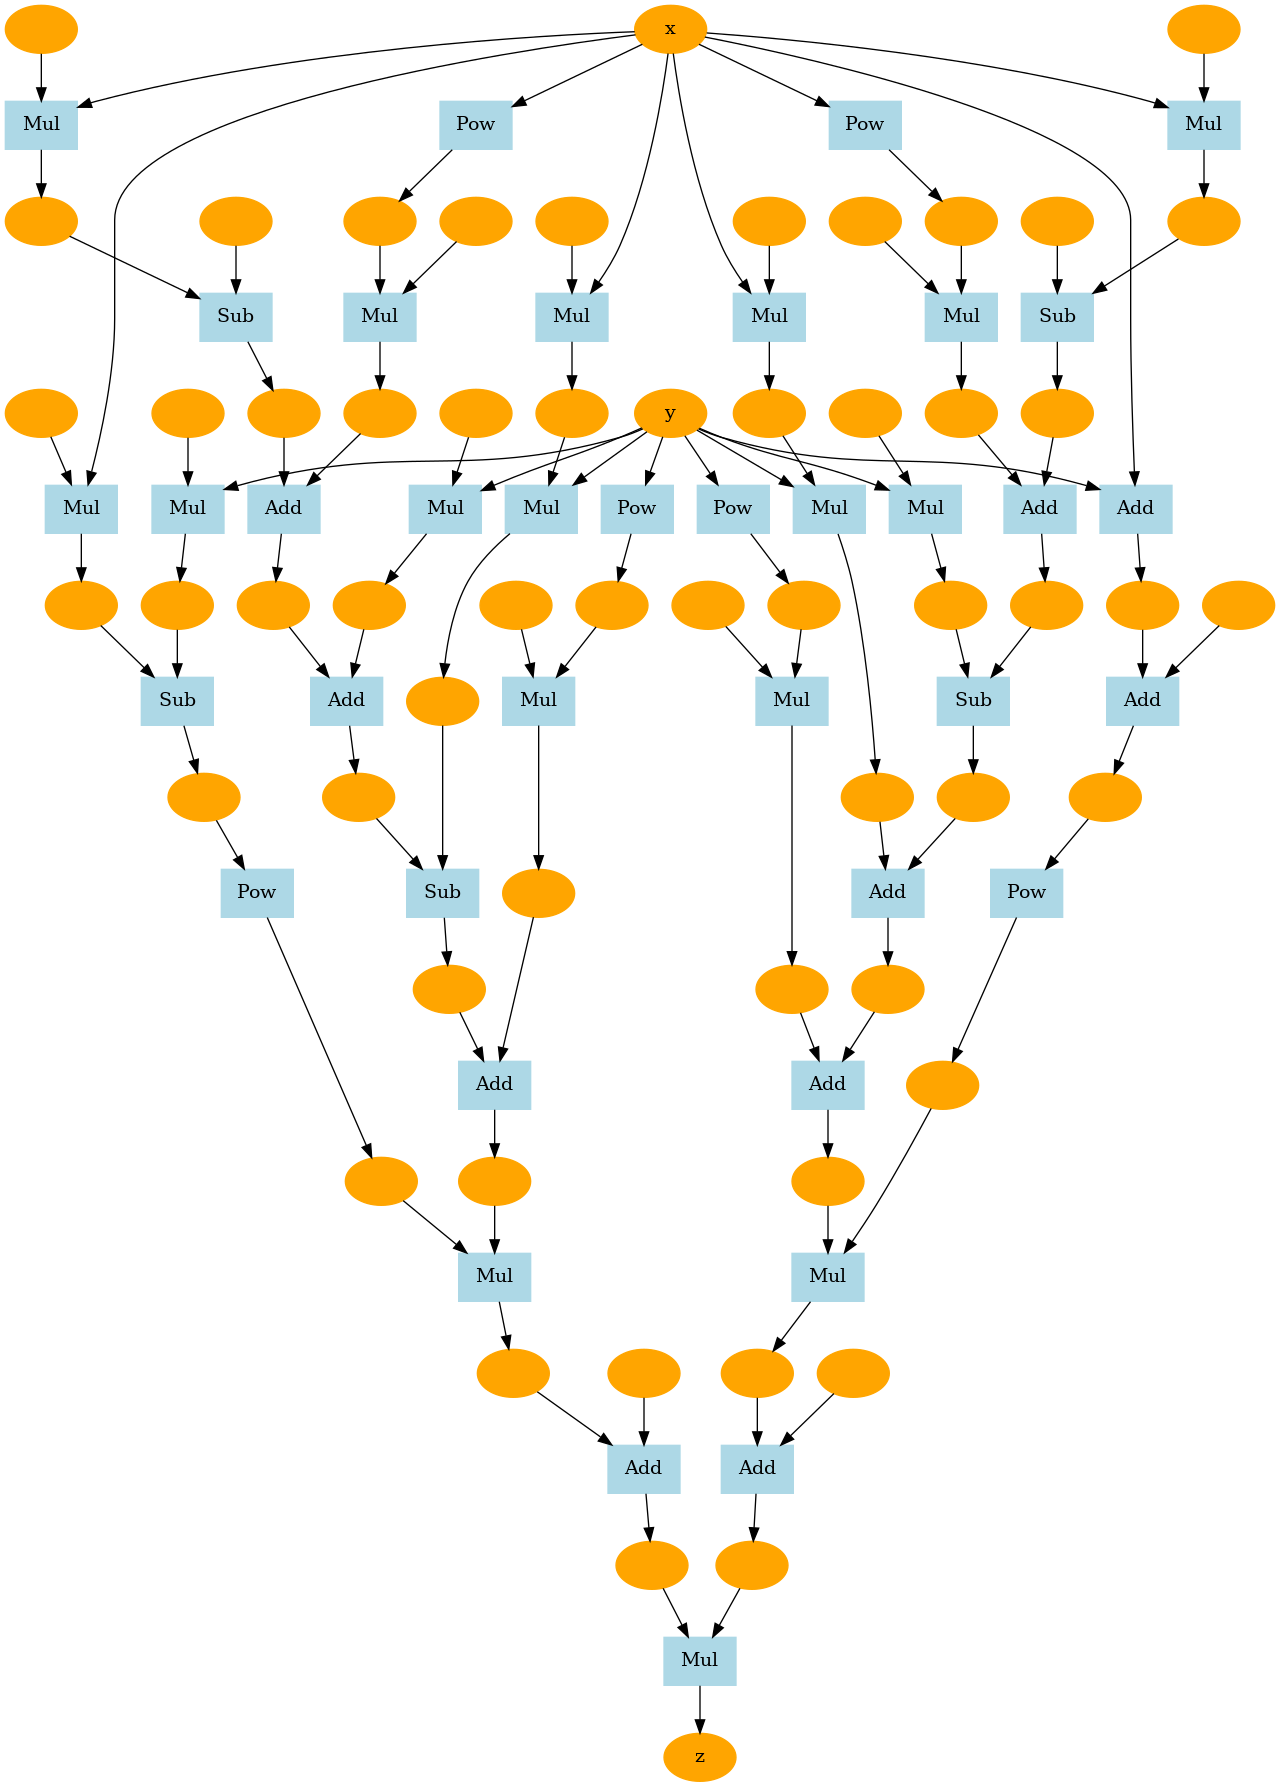

In [1]:
import numpy as np
from dezero import Variable
from dezero.utils import plot_dot_graph

def goldstein(x, y):
    return (1 + (x + y + 1)**2 * (19 - 14*x + 3*x**2 - 14*y + 6*x*y + 3*y**2)) * \
        (30 + (2*x - 3*y)**2 * (18 - 32*x + 12*x**2 + 48*y - 36*x*y + 27*y**2))

x = Variable(np.array(1.0))
y = Variable(np.array(1.0))
z = goldstein(x, y)
z.backward()

x.name = 'x'
y.name = 'y'
z.name = 'z'
plot_dot_graph(z, verbose=False, to_file='goldstein.png')

### **16. 최적화 알고리즘**

In [6]:
import numpy as np
from dezero import Variable

**16-1. 경사하강법**

- 초기값으로부터 미분값을 구한 뒤, 이를 반영하여 다음 포인트를 갱신

In [7]:
def rosenbrock(x0, x1):
    return 100 * (x1 - x0 ** 2) ** 2 + (1 - x0) ** 2

x0, x1 = Variable(np.array(0.0)), Variable(np.array(2.0))
lr = 0.001
iters = 1000

for _ in range(iters):
    print(x0, x1)

    y = rosenbrock(x0, x1)

    x0.cleargrad()
    x1.cleargrad()
    y.backward()

    x0.data -= lr * x0.grad
    x1.data -= lr * x1.grad

variable(0.0) variable(2.0)
variable(0.002) variable(1.6)
variable(0.0052759968) variable(1.2800008)
variable(0.009966698110960038) variable(1.0240062072284468)
variable(0.01602875299014943) variable(0.8192248327970044)
variable(0.02324750923068761) variable(0.6554312504220874)
variable(0.031290846214210376) variable(0.5244530896747561)
variable(0.039780241951514035) variable(0.41975829515116514)
variable(0.04835473570612382) variable(0.3361231296508763)
variable(0.05671405943493354) variable(0.26936613981374286)
variable(0.06463840226323121) variable(0.2161362087585121)
variable(0.07198937826156711) variable(0.17374459161623834)
variable(0.07869927242171229) variable(0.14003216740948807)
variable(0.08475507379959696) variable(0.11326444902353183)
variable(0.0901819257435144) variable(0.0920482437257805)
variable(0.09502862514911821) variable(0.07526515092678615)
variable(0.09935624532071949) variable(0.062018208660975245)
variable(0.10322996680416148) variable(0.05158889962562639)
var

**16-2. 뉴턴 방법**

- 특정 함수를 2차 함수로 근사하여 다음 포인트를 갱신
- 경사하강법과 달리 학습률을 자동으로 조정

In [8]:
def f(x):
    return x ** 4 - 2 * x ** 2

def gx2(x):
    return 12 * x ** 2 - 4

x = Variable(np.array(2.0))
iters = 10

for _ in range(iters):
    print(x)

    y = f(x)
    x.cleargrad()
    y.backward()

    x.data -= x.grad / gx2(x.data)

variable(2.0)
variable(1.4545454545454546)
variable(1.1510467893775467)
variable(1.0253259289766978)
variable(1.0009084519430513)
variable(1.0000012353089454)
variable(1.000000000002289)
variable(1.0)
variable(1.0)
variable(1.0)


### **17. 고차 미분**

In [1]:
import numpy as np
from dezero import Variable

In [4]:
def f(x):
    return x ** 4 - 2 * x ** 2

x = Variable(np.array(2.0))

# 1차 미분
y = f(x)
y.backward(create_graph=True)
print(x.grad)

# 2차 미분
gx = x.grad
x.cleargrad()
gx.backward()
print(x.grad)


variable(24.0)
variable(44.0)


In [5]:
x = Variable(np.array(2.0))
iters = 10

for _ in range(iters):
    print(x)

    # 1차 미분
    y = f(x)
    x.cleargrad()
    y.backward(create_graph=True)

    # 2차 미분
    gx = x.grad
    x.cleargrad()
    gx.backward()
    gx2 = x.grad
    
    x.data -= gx.data / gx2.data    
    

variable(2.0)
variable(1.4545454545454546)
variable(1.1510467893775467)
variable(1.0253259289766978)
variable(1.0009084519430513)
variable(1.0000012353089454)
variable(1.000000000002289)
variable(1.0)
variable(1.0)
variable(1.0)


### **18. Sin / Cos / Tanh**

In [1]:
import numpy as np
import dezero.functions as F
import matplotlib.pyplot as plt

from dezero import Variable
from dezero.utils import plot_dot_graph

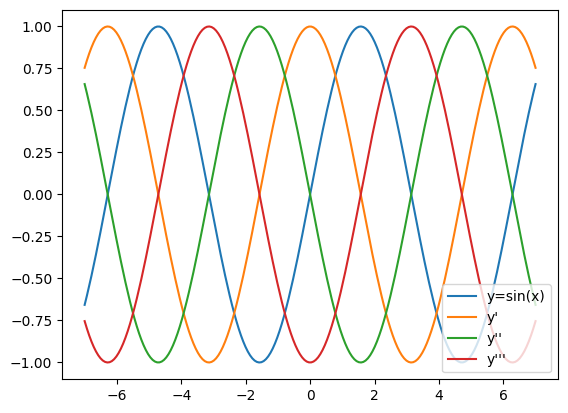

In [2]:
x = Variable(np.linspace(-7, 7, 200))
y = F.sin(x)
y.backward(create_graph=True)

logs = [y.data]

# n차 미분 진행
for _ in range(3):
    logs.append(x.grad.data)
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

# 그래프 그리기
labels = ["y=sin(x)", "y'", "y''", "y'''"]
for i, v in enumerate(logs):
    plt.plot(x.data, logs[i], label=labels[i])
plt.legend(loc='lower right')
plt.show()

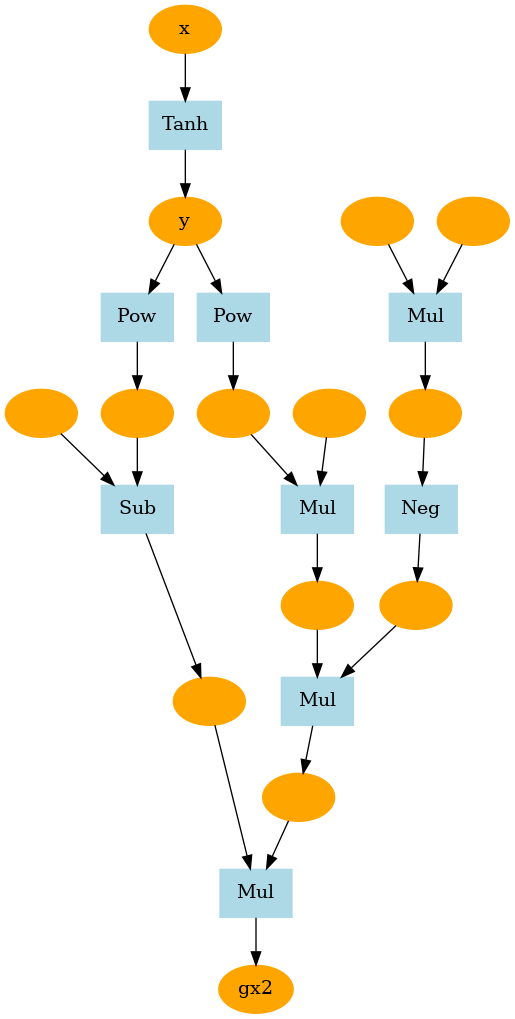

In [3]:
x = Variable(np.array(1.0))
y = F.tanh(x)
x.name = 'x'
y.name = 'y'
y.backward(create_graph=True)

iters = 1
for _ in range(iters):
    gx = x.grad
    x.cleargrad()
    gx.backward(create_graph=True)

gx = x.grad
gx.name = 'gx' + str(iters+1)
plot_dot_graph(gx, verbose=False, to_file='tanh.png')

### **19. 고차 미분 응용**

- 특정 함수(손실 함수)의 기울기를 다시 손실 함수에 활용하는 문제 최적화에 적용 가능
- Double Backpropagation이라 부름

In [4]:
import numpy as np
from dezero import Variable

x = Variable(np.array(2.0))
y = x ** 2
y.backward(create_graph=True)
gx = x.grad

x.cleargrad()
z = gx ** 3 + y
z.backward()

print(x.grad)

variable(100.0)


### **20. Reshpae & Transpose**

In [1]:
import numpy as np
from dezero import Variable

In [4]:
x = Variable(np.random.randn(1, 2, 3))
y = x.reshape(2, 3) # == x.reshape((2, 3))
print(y.shape)

(2, 3)


In [5]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = x.transpose() # == x.T
print(y.shape)

(3, 2)


### **21. BroadCasting & Sum**

In [1]:
import numpy as np
import dezero.functions as F

from dezero import Variable

In [2]:
x = Variable(np.array([[1, 2, 3], [4, 5, 6]]))
y = F.sum(x, axis=0)
y.backward()

print(y)
print(x.grad)

variable([5 7 9])
variable([[1 1 1]
          [1 1 1]])


In [4]:
x0 = Variable(np.array([1, 2, 3]))
x1 = Variable(np.array([10]))

y = x0 + x1
print(y)

y.backward()
print(x1.grad)

variable([11 12 13])
variable([1 1 1])


### **22. 행렬 곱셈 (Matrix Multiplication)**

In [2]:
import numpy as np
import dezero.functions as F
from dezero import Variable

x = Variable(np.random.randn(2, 3))
W = Variable(np.random.randn(3, 4))
y = F.matmul(x, W)
y.backward()

print(x.grad.shape)
print(W.grad.shape)

(2, 3)
(3, 4)


### **23. 선형 회귀 (Linear Regression)**

- 평균 제곱 오차 (Mean Squared Error, MSE) 구현
- 선형 변환 (Linear Transformation) 구현

In [1]:
import matplotlib.pyplot as plt
from dezero import as_variable

def plot_graph(x, y, y_pred=None):
    x = as_variable(x)
    y = as_variable(y)

    plt.scatter(x.data, y.data, s=10)
    plt.xlabel('x')
    plt.ylabel('y')

    if y_pred is not None:
        y_pred = as_variable(y_pred)
        plt.plot(x.data, y_pred.data, color='r')

    plt.show()

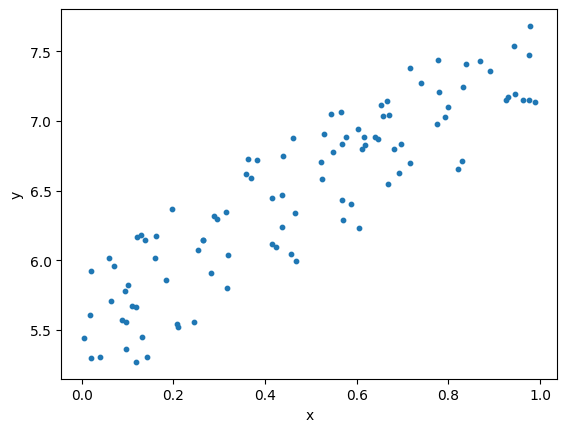

In [2]:
import numpy as np

np.random.seed(0)
x = np.random.rand(100, 1)
y = 5 + 2 * x + np.random.rand(100, 1)

plot_graph(x, y)

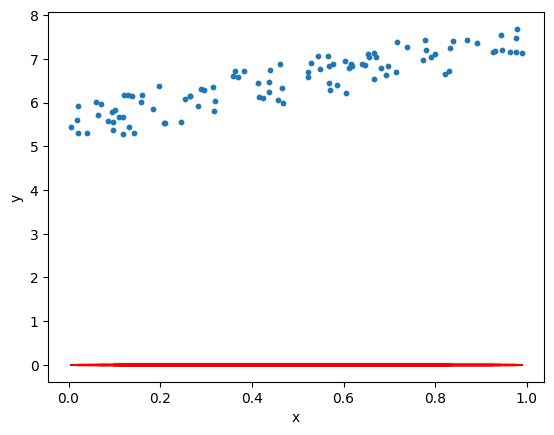

In [16]:
import dezero.functions as F
from dezero import Variable

W = Variable(np.zeros((1, 1)))
b = Variable(np.zeros(1))

def predict(x):
    y = F.linear(x, W, b)
    return y

y_pred = predict(x)
plot_graph(x, y, y_pred)

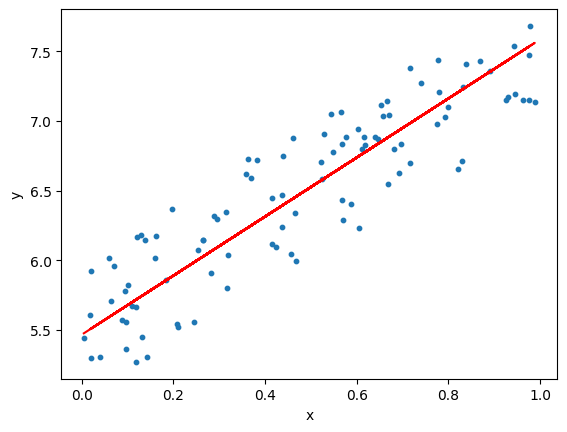

In [17]:
lr = 0.1
iters = 100

for _ in range(iters):
    y_pred = predict(x)
    loss = F.mean_squared_error(y, y_pred)

    W.cleargrad()
    b.cleargrad()
    loss.backward()

    W.data -= lr * W.grad.data
    b.data -= lr * b.grad.data

plot_graph(x, y, y_pred)